In [1]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read in data
df = pd.read_csv('../data/df_clean.csv', index_col=0, parse_dates=True)

## Categoricals

In [3]:
# Get Categorical columns
categorical = df.select_dtypes(include='object')

# Instationate LabelEncoder, fit and transform on wind_direction cols
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df['wind_madrid'])
for col in categorical.filter(regex='wind').columns:
    df[col] = wind_dir_coder.transform(df[col])
    

# Stack condition columns into single col
stacked_conditions = categorical.filter(regex='condition').stack()

# Instantiate Label encoder, fit and transform on condition cols
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)
for col in categorical.filter(regex='condition').columns:
    df[col] = condition_coder.transform(df[col])

## Split Data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price_tomorrow']), df['price_tomorrow'], test_size=.3,
                                                    random_state=17)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=17)

## XGB Train Previous Years, Predict Next Year

In [4]:
forecast_corrs = [(np.corrcoef(df.loc[str(num), 'price_tomorrow'], df.loc[str(num), 'price_forecast_tomorrow'])**2)[0][1] for num in range(2016,2022,1)]
results_prev_year = pd.DataFrame(index=range(2016,2022,1), columns=['TSO_Forecast', 'RF_Wo_Forecast', 'RF_W_Forecast'])

In [5]:
results_prev_year['TSO_Forecast'] = forecast_corrs
def fit_prev_years(data, test_year, results_df):
        for col in ['RF_Wo_Forecast', 'RF_W_Forecast']:
            X_train = data.loc[:str(test_year-1)].drop(columns='price_tomorrow')
            X_test = data.loc[str(test_year)].drop(columns='price_tomorrow')
            if col == 'RF_Wo_Forecast':
                X_train = X_train.drop(columns='price_forecast_tomorrow')
                X_test = X_test.drop(columns='price_forecast_tomorrow')
            y_train = data.loc[:str(test_year-1), 'price_tomorrow']
            y_test = data.loc[str(test_year), 'price_tomorrow']
            xg = XGBRegressor(random_state=17)
            xg.fit(X_train, y_train)
            preds_val = xg.predict(X_test)
            r2 = (np.corrcoef(preds_val, y_test)**2)[0][1]
            results_df.loc[test_year, col] = r2

In [6]:
df_raw=df.copy()
df.drop(columns='price_actual', inplace=True)

In [15]:
fit_prev_years(df, 2016, results_prev_year)
fit_prev_years(df, 2017, results_prev_year)
fit_prev_years(df, 2018, results_prev_year)
fit_prev_years(df, 2019, results_prev_year)
fit_prev_years(df, 2020, results_prev_year)
fit_prev_years(df, 2021, results_prev_year)

In [18]:
results_prev_year['diff'] = results_prev_year['RF_W_Forecast']-results_prev_year['TSO_Forecast']
results_prev_year

,TSO_Forecast,RF_Wo_Forecast,RF_W_Forecast,diff
2016,0.985954,0.537381,0.976418,-0.009535
2017,0.977560,0.575894,0.96134,-0.016221
2018,0.980869,0.393488,0.981602,0.000733
2019,0.976052,0.525094,0.979262,0.00321
2020,0.971478,0.477174,0.965989,-0.005489
2021,0.997500,0.192425,0.490489,-0.507012


In [17]:
results_prev_year_raw = pd.DataFrame(index=range(2016,2022,1), columns=['TSO_Forecast', 'RF_Wo_Forecast', 'RF_W_Forecast'])
results_prev_year_raw['TSO_Forecast'] = forecast_corrs

fit_prev_years(df_raw, 2016, results_prev_year_raw)
fit_prev_years(df_raw, 2017, results_prev_year_raw)
fit_prev_years(df_raw, 2018, results_prev_year_raw)
fit_prev_years(df_raw, 2019, results_prev_year_raw)
fit_prev_years(df_raw, 2020, results_prev_year_raw)
fit_prev_years(df_raw, 2021, results_prev_year_raw)
results_prev_year_raw

,TSO_Forecast,RF_Wo_Forecast,RF_W_Forecast
2016,0.985954,0.642098,0.976874
2017,0.977560,0.781403,0.95794
2018,0.980869,0.805783,0.982944
2019,0.976052,0.783991,0.979132
2020,0.971478,0.651976,0.968971
2021,0.997500,0.397066,0.523108


In [9]:
forecast_corrs = [(np.corrcoef(df.loc[str(num), 'price_tomorrow'], df.loc[str(num), 'price_forecast_tomorrow'])**2)[0][1] for num in range(2016,2022,1)]
results_year = pd.DataFrame(index=range(2016,2022,1), columns=['TSO_Forecast', 'RF_Wo_Forecast', 'RF_W_Forecast'])
results_year['TSO_Forecast'] = forecast_corrs
def fit_rf_year(data, test_year, results_df):
    indices = data.loc[str(test_year)].index
    for col in ['RF_Wo_Forecast', 'RF_W_Forecast']:
        X_train = data.drop(index=indices).drop(columns='price_tomorrow')
        X_test = data.loc[str(test_year)].drop(columns='price_tomorrow')
        if col == 'RF_Wo_Forecast':
            X_train = X_train.drop(columns='price_forecast_tomorrow')
            X_test = X_test.drop(columns='price_forecast_tomorrow')
        y_train = data.drop(index=indices).loc[:, 'price_tomorrow']
        y_test = data.loc[str(test_year), 'price_tomorrow']
        xg = XGBRegressor(random_state=17)
        xg.fit(X_train, y_train)
        preds_val = xg.predict(X_test)
        r2 = (np.corrcoef(preds_val, y_test)**2)[0][1]
        results_df.loc[test_year, col] = r2

In [10]:
fit_rf_year(df, 2016, results_year)
fit_rf_year(df, 2017, results_year)
fit_rf_year(df, 2018, results_year)
fit_rf_year(df, 2019, results_year)
fit_rf_year(df, 2020, results_year)
fit_rf_year(df, 2021, results_year)

In [19]:
results_year['diff'] = results_year['RF_W_Forecast'] - results_year['TSO_Forecast']
results_year

,TSO_Forecast,RF_Wo_Forecast,RF_W_Forecast,diff
2016,0.985954,0.440735,0.967682,-0.018272
2017,0.977560,0.382027,0.98007,0.00251
2018,0.980869,0.351092,0.982912,0.002043
2019,0.976052,0.170477,0.981486,0.005435
2020,0.971478,0.180774,0.973687,0.002209
2021,0.997500,0.192425,0.490489,-0.507012


In [21]:
forecast_corrs = [(np.corrcoef(df.loc[str(num), 'price_tomorrow'], df.loc[str(num), 'price_forecast_tomorrow'])**2)[0][1] for num in range(2016,2022,1)]
results_year_raw['TSO_Forecast'] = forecast_corrs
results_year_raw = pd.DataFrame(index=range(2016,2022,1), columns=['TSO_Forecast', 'RF_Wo_Forecast', 'RF_W_Forecast'])
fit_rf_year(df_raw, 2016, results_year_raw)
fit_rf_year(df_raw, 2017, results_year_raw)
fit_rf_year(df_raw, 2018, results_year_raw)
fit_rf_year(df_raw, 2019, results_year_raw)
fit_rf_year(df_raw, 2020, results_year_raw)
fit_rf_year(df_raw, 2021, results_year_raw)
results_year_raw['diff'] = results_year_raw['RF_W_Forecast'] - results_year_raw['TSO_Forecast']
results_year_raw

,TSO_Forecast,RF_Wo_Forecast,RF_W_Forecast,diff
2016,0.985954,0.800099,0.973754,-0.012199
2017,0.977560,0.811354,0.981196,0.003636
2018,0.980869,0.832145,0.984726,0.003857
2019,0.976052,0.790396,0.980994,0.004943
2020,0.971478,0.498731,0.973784,0.002307
2021,0.997500,0.397066,0.523108,-0.474392


## Look at specific Model

In [28]:
X_train = df.loc[:'2019'].drop(columns=['price_actual', 'price_tomorrow'])
X_test = df.loc['2020'].drop(columns=['price_actual', 'price_tomorrow'])
y_train = df.loc[:'2019', 'price_tomorrow']
y_test = df.loc['2020', 'price_tomorrow']

In [31]:
xg = XGBRegressor(random_state=17)
xg.fit(X_train, y_train)
preds = xg.predict(X_test)
r2 = (np.corrcoef(preds, y_test)**2)[0][1]
print(r2)

0.46064717969814745


In [39]:
results = pd.DataFrame({'importance':xg.feature_importances_}, index=X_train.columns)
results.sort_values(by='importance', ascending=False).head(10)

,importance
price_forecast_tomorrow,0.360135
pressures_bilbao,0.031431
pressures_madrid,0.031348
total load actual,0.022519
generation fossil hard coal,0.020103
pressures_barcelona,0.019522
dew_point_valencia,0.019426
generation nuclear,0.016799
wind_speeds_madrid,0.016538
dew_point_bilbao,0.015592


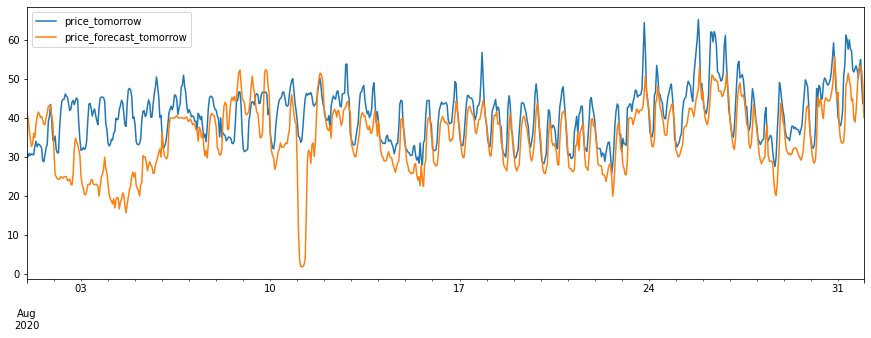

In [78]:
df_raw.loc['2020-8', ['price_tomorrow', 'price_forecast_tomorrow']].plot(figsize=(15,5));
preds

In [47]:
df_raw['price_diff'] = df_raw['price_tomorrow'] - df_raw['price_forecast_tomorrow']

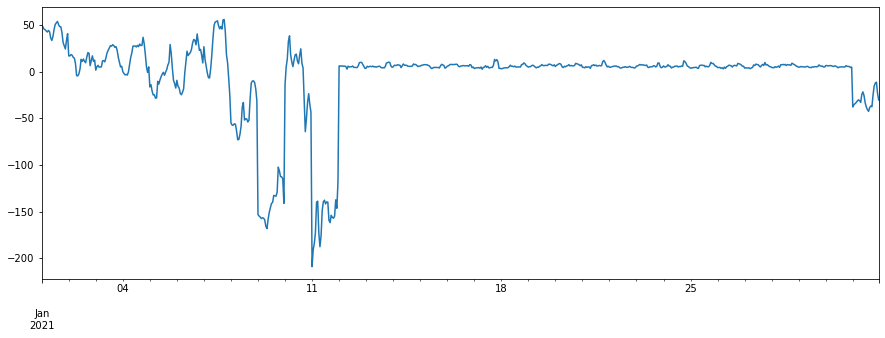

In [105]:
df_raw.loc['2021-1','price_diff'].plot(figsize=(15,5));

In [106]:
df_raw.loc['2021-1-11', ['price_actual', 'price_tomorrow', 'price_forecast_tomorrow', 'price_diff']]

,price_actual,price_tomorrow,price_forecast_tomorrow,price_diff
2021-01-11 00:00:00,64.27,80.18,289.10,-208.92
2021-01-11 01:00:00,59.81,68.31,259.05,-190.74
2021-01-11 02:00:00,57.29,62.20,246.25,-184.05
2021-01-11 03:00:00,54.51,60.77,232.97,-172.20
2021-01-11 04:00:00,53.27,60.38,200.30,-139.92
2021-01-11 05:00:00,58.98,61.22,200.00,-138.78
2021-01-11 06:00:00,68.65,71.02,244.00,-172.98
2021-01-11 07:00:00,82.85,86.13,273.73,-187.60
2021-01-11 08:00:00,101.05,104.25,280.10,-175.85
2021-01-11 09:00:00,103.37,111.12,260.00,-148.88


In [96]:
df

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,wind_speeds_bilbao,pressures_bilbao,condition_bilbao,temp_valencia,dew_point_valencia,humidities_valencia,wind_valencia,wind_speeds_valencia,pressures_valencia,condition_valencia
2015-01-01 00:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,5.0,30.50,59,41.0,37.0,87.0,17,3.0,30.19,4
2015-01-01 01:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,5.0,30.50,59,39.0,37.0,93.0,16,3.0,30.19,4
2015-01-01 02:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,5.0,30.50,59,37.0,36.0,93.0,15,5.0,30.22,4
2015-01-01 03:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,5.0,30.50,59,37.0,36.0,93.0,15,3.0,30.25,4
2015-01-01 04:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,5.0,30.50,59,37.0,36.0,93.0,16,3.0,30.25,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-30 19:00:00,539.0,0.0,5814.0,1391.0,203.0,218.0,1466.0,5034.0,6083.0,56.0,...,6.0,30.00,4,61.0,50.0,68.0,2,3.0,29.98,4
2021-12-30 20:00:00,542.0,0.0,5822.0,1399.0,204.0,218.0,1488.0,5239.0,6086.0,56.0,...,7.0,30.00,4,59.0,50.0,72.0,2,3.0,29.98,4
2021-12-30 21:00:00,545.0,0.0,5738.0,1421.0,204.0,218.0,1435.0,4514.0,6088.0,56.0,...,9.0,30.00,4,52.0,48.0,88.0,8,3.0,30.01,4
2021-12-30 22:00:00,539.0,0.0,5543.0,1420.0,203.0,221.0,1373.0,3473.0,6088.0,56.0,...,8.0,30.03,4,50.0,46.0,87.0,8,5.0,29.98,4


## Model

In [6]:
xgb_0 = XGBRegressor(random_state=17)
xgb_0.fit(X_train, y_train)
train_preds_0 = xgb_0.predict(X_train)
val_preds_0 = xgb_0.predict(X_val)


In [7]:
print('r-squared train:', xgb_0.score(X_train,y_train))
print('r-squared val:', xgb_0.score(X_val,y_val))

r-squared train: 0.992261848401456
r-squared val: 0.9725463852199624


In [8]:
X_val.sort_index(inplace=True)
y_val.sort_index(inplace=True)
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)

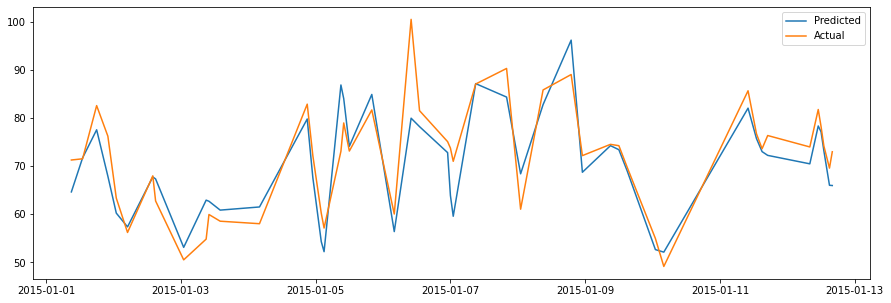

In [11]:
fig = plt.figure(figsize=(15,5))
plt.plot(X_val.index[:48], xgb_0.predict(X_val)[:48], label='Predicted');
plt.plot(y_val.index[:48], y_val.values[:48], label='Actual');
plt.legend();

## Predict Each Year with XGBoost

In [12]:
# Read in data
df = pd.read_csv('../data/df_clean.csv', index_col=0, parse_dates=True)

# Get Categorical columns
categorical = df.select_dtypes(include='object')

# Instationate LabelEncoder, fit and transform on wind_direction cols
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df['wind_madrid'])
for col in categorical.filter(regex='wind').columns:
    df[col] = wind_dir_coder.transform(df[col])
    

# Stack condition columns into single col
stacked_conditions = categorical.filter(regex='condition').stack()

# Instantiate Label encoder, fit and transform on condition cols
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)
for col in categorical.filter(regex='condition').columns:
    df[col] = condition_coder.transform(df[col])

In [13]:
# Split data and target
X_train = df.loc['2016':'2021'].drop(columns=['price_forecast_tomorrow', 'price_tomorrow'])
X_test  = df.loc['2015'].drop(columns=['price_forecast_tomorrow', 'price_tomorrow'])

y_train = df.loc['2016':'2021','price_tomorrow']
y_test = df.loc['2015','price_tomorrow']

xgb_1 = XGBRegressor(random_state=17)
xgb_1.fit(X_train, y_train)

print('r-squared train:', xgb_1.score(X_train,y_train))
print('r-squared val:', xgb_1.score(X_test,y_test))

r-squared train: 0.9905890048676856
r-squared val: 0.4650389304594402


In [14]:
# Split data and target
X_train = df.loc['2016':'2021'].drop(columns=[ 'price_tomorrow'])
X_test  = df.loc['2015'].drop(columns=['price_tomorrow'])

y_train = df.loc['2016':'2021','price_tomorrow']
y_test = df.loc['2015','price_tomorrow']

xgb_1_1 = XGBRegressor(random_state=17)
xgb_1_1.fit(X_train, y_train)

print('r-squared train:', xgb_1_1.score(X_train,y_train))
print('r-squared val:', xgb_1_1.score(X_test,y_test))

r-squared train: 0.9928425003474801
r-squared val: 0.5281331457357064


## 2016

In [15]:
# Split data and target
X_train = df.loc['2015' and '2017':].drop(columns=['price_forecast_tomorrow', 'price_tomorrow'])
X_test  = df.loc['2016'].drop(columns=['price_forecast_tomorrow', 'price_tomorrow'])

y_train = df.loc['2015' and '2017':,'price_tomorrow']
y_test = df.loc['2016', 'price_tomorrow']

xgb_2 = XGBRegressor(random_state=17)
xgb_2.fit(X_train, y_train)

print('r-squared train:', xgb_2.score(X_train,y_train))
print('r-squared val:', xgb_2.score(X_test,y_test))

r-squared train: 0.9925988670950249
r-squared val: 0.5660236817606981


In [16]:
# Split data and target
X_train = df.loc['2015' and '2017':].drop(columns=['price_tomorrow'])
X_test  = df.loc['2016'].drop(columns=['price_tomorrow'])

y_train = df.loc['2015' and '2017':,'price_tomorrow']
y_test = df.loc['2016', 'price_tomorrow']

xgb_2 = XGBRegressor(random_state=17)
xgb_2.fit(X_train, y_train)

print('r-squared train:', xgb_2.score(X_train,y_train))
print('r-squared val:', xgb_2.score(X_test,y_test))

r-squared train: 0.993878718786195
r-squared val: 0.6650866255762657


## 2021

In [17]:
# Split data and target
X_train = df.loc[:'2016'].drop(columns=['price_forecast_tomorrow', 'price_tomorrow'])
X_test  = df.loc['2021'].drop(columns=['price_forecast_tomorrow', 'price_tomorrow'])

y_train = df.loc[:'2016','price_tomorrow']
y_test = df.loc['2021', 'price_tomorrow']

xgb_20 = XGBRegressor(random_state=17)
xgb_20.fit(X_train, y_train)

print('r-squared train:', xgb_20.score(X_train,y_train))
print('r-squared val:', xgb_20.score(X_test,y_test))

r-squared train: 0.9776395810860347
r-squared val: -0.5533566512343224


In [18]:
# Split data and target
X_train = df.loc[:'2019'].drop(columns=['price_forecast_tomorrow', 'price_tomorrow'])
X_test  = df.loc['2020'].drop(columns=['price_forecast_tomorrow', 'price_tomorrow'])

y_train = df.loc[:'2019','price_tomorrow']
y_test = df.loc['2020', 'price_tomorrow']

xgb_20 = XGBRegressor(random_state=17)
xgb_20.fit(X_train, y_train)

print('r-squared train:', xgb_20.score(X_train,y_train))
print('r-squared val:', xgb_20.score(X_test,y_test))

r-squared train: 0.9476620362006827
r-squared val: 0.11740837090908118


In [19]:
# Split data and target
X_train = df.loc[:'2019'].drop(columns=['price_tomorrow'])
X_test  = df.loc['2020'].drop(columns=['price_tomorrow'])

y_train = df.loc[:'2019','price_tomorrow']
y_test = df.loc['2020', 'price_tomorrow']

xgb_20_1 = XGBRegressor(random_state=17)
xgb_20_1.fit(X_train, y_train)

print('r-squared train:', xgb_20_1.score(X_train,y_train))
print('r-squared val:', xgb_20_1.score(X_test,y_test))

r-squared train: 0.9580161113352178
r-squared val: 0.5735110833000343


## 2020

In [20]:
# Split data and target
X_train = df.loc[:'2019' and '2021'].drop(columns=['price_forecast_tomorrow', 'price_tomorrow'])
X_test  = df.loc['2020'].drop(columns=['price_forecast_tomorrow', 'price_tomorrow'])

y_train = df.loc[:'2019' and '2021','price_tomorrow']
y_test = df.loc['2020', 'price_tomorrow']

xgb_21 = XGBRegressor(random_state=17)
xgb_21.fit(X_train, y_train)

print('r-squared train:', xgb_21.score(X_train,y_train))
print('r-squared val:', xgb_21.score(X_test,y_test))

r-squared train: 0.9890923602708974
r-squared val: 0.8530203754520999


In [21]:
# Split data and target
X_train = df.loc[:'2019' and '2021'].drop(columns=['price_tomorrow'])
X_test  = df.loc['2020'].drop(columns=['price_tomorrow'])

y_train = df.loc[:'2019' and '2021','price_tomorrow']
y_test = df.loc['2020', 'price_tomorrow']

xgb_21_1 = XGBRegressor(random_state=17)
xgb_21_1.fit(X_train, y_train)

print('r-squared train:', xgb_21_1.score(X_train,y_train))
print('r-squared val:', xgb_21_1.score(X_test,y_test))

r-squared train: 0.9916241693594944
r-squared val: 0.8914622626633227


In [48]:
import matplotlib.pyplot as plt

In [93]:
X_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_test.sort_index(inplace=True)

C:\Users\holde\anaconda3\lib\site-packages\pandas\core\series.py:3424: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().sort_index(


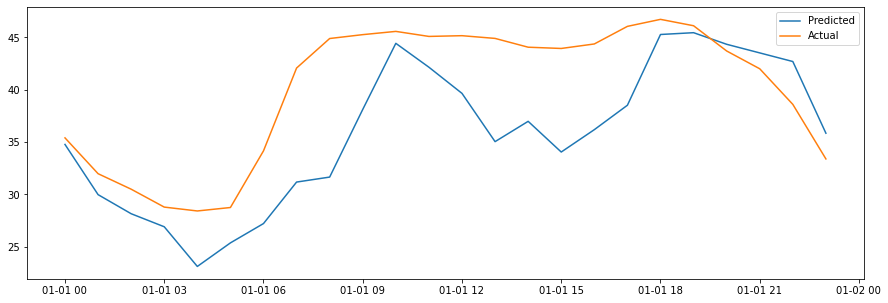

In [22]:
fig = plt.figure(figsize=(15,5))
plt.plot(X_test.index[:24], xgb_21_1.predict(X_test)[:24], label='Predicted');
plt.plot(y_test.index[:24], y_test.values[:24], label='Actual');
plt.legend();

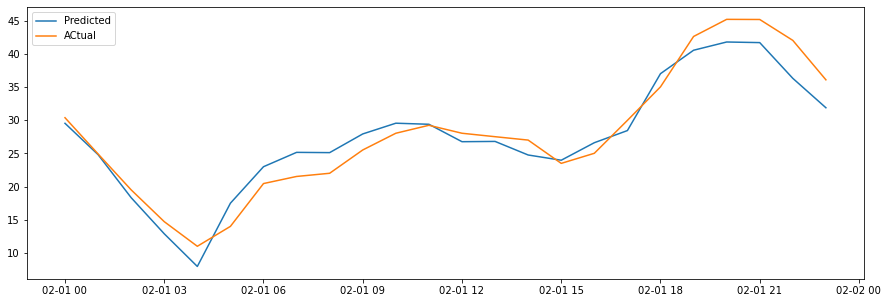

In [23]:
fig = plt.figure(figsize=(15,5))
plt.plot(X_test.index[24:48], xgb_21_1.predict(X_test)[24:48], label='Predicted');
plt.plot(y_test.index[24:48], y_test.values[24:48], label='ACtual');
plt.legend();

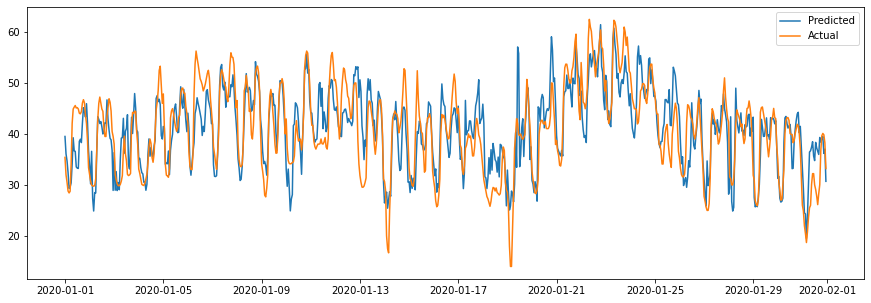

In [99]:
fig = plt.figure(figsize=(15,5))
plt.plot(X_test.index[:744], xgb_21_1.predict(X_test)[:744], label='Predicted');
plt.plot(y_test.index[:744], y_test.values[:744], label='Actual');
plt.legend();

In [81]:
y_test.

2020-01-01 00:00:00    35.40
2020-01-01 01:00:00    31.98
2020-01-01 02:00:00    30.50
2020-01-01 03:00:00    28.79
2020-01-01 04:00:00    28.42
2020-01-01 05:00:00    28.75
2020-01-01 06:00:00    34.16
2020-01-01 07:00:00    42.07
2020-01-01 08:00:00    44.89
2020-01-01 09:00:00    45.26
2020-01-01 10:00:00    45.57
2020-01-01 11:00:00    45.09
2020-01-01 12:00:00    45.16
2020-01-01 13:00:00    44.90
2020-01-01 14:00:00    44.06
2020-01-01 15:00:00    43.94
2020-01-01 16:00:00    44.37
2020-01-01 17:00:00    46.05
2020-01-01 18:00:00    46.72
2020-01-01 19:00:00    46.11
2020-01-01 20:00:00    43.70
2020-01-01 21:00:00    42.00
2020-01-01 22:00:00    38.60
2020-01-01 23:00:00    33.39
2020-02-01 00:00:00    30.37
2020-02-01 01:00:00    24.91
2020-02-01 02:00:00    19.50
2020-02-01 03:00:00    14.71
2020-02-01 04:00:00    11.00
2020-02-01 05:00:00    14.00
2020-02-01 06:00:00    20.45
2020-02-01 07:00:00    21.52
2020-02-01 08:00:00    22.00
2020-02-01 09:00:00    25.51
2020-02-01 10:

In [78]:
y_test.groupby(by = [y_test.index.month, y_test.index.day,]).count()

1   1     24
    2     24
    3     24
    4     24
    5     24
          ..
12  27    24
    28    24
    29    24
    30    24
    31    24
Name: price tomorrow, Length: 366, dtype: int64

In [79]:
len(y_test)

8784

In [114]:
df.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'generation total', 'diff', 'generation_scheduled',
       'consumption_scheduled', 'transmission_ps', 'transmission_sp',
       'transmission_fs', 'transmission_sf', 'temp_madrid', 'dew_point_madrid',
       'humidities_madrid', 'wind_madrid', 'wind_speeds_madrid',
       'pressures_madrid', 'condition_madrid', 'temp_seville',
       'dew_point_seville', 'humidities_seville

In [155]:
def to_list(x):
    return [i for i in x]
        

In [161]:
df.groupby(by=[df.index.year, df.index.month, df.index.day]).apply(list)

2015  1   1     [generation biomass, generation fossil brown c...
          2     [generation biomass, generation fossil brown c...
          3     [generation biomass, generation fossil brown c...
          4     [generation biomass, generation fossil brown c...
          5     [generation biomass, generation fossil brown c...
                                      ...                        
2021  12  26    [generation biomass, generation fossil brown c...
          27    [generation biomass, generation fossil brown c...
          28    [generation biomass, generation fossil brown c...
          29    [generation biomass, generation fossil brown c...
          30    [generation biomass, generation fossil brown c...
Length: 2544, dtype: object

In [181]:
range_ = pd.date_range(dt.datetime(2015,1,1), dt.datetime(2021,12,31), freq='D')[:10]
range_  = [str(x)[:10] for x in range_]
df_2 = pd.DataFrame(columns = df.columns)
for day in range_:
    try:
        df_2 = pd.concat([df_2, df.loc[day]], axis=0)
    except KeyError:
        continue

In [191]:
df.loc[range_[0]]['generation biomass'].values

array([447., 449., 448., 438., 428., 410., 401., 408., 413., 419., 422.,
       421., 428., 425., 423., 421., 422., 426., 427., 442., 445., 443.,
       440., 438.])

In [180]:
[str(x)[:10] for x in range_]

['2015-01-01',
 '2015-01-02',
 '2015-01-03',
 '2015-01-04',
 '2015-01-05',
 '2015-01-06',
 '2015-01-07',
 '2015-01-08',
 '2015-01-09',
 '2015-01-10']